In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samuelcortinhas/sports-balls-multiclass-image-classification")

print("Path to dataset files:", path)


100%|██████████| 401M/401M [00:03<00:00, 132MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2


In [ ]:
import os, itertools

SRC = "/root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2"
print("SRC exists:", os.path.exists(SRC))

for root, dirs, files in itertools.islice(os.walk(SRC), 3):
    print("DIR:", root)
    sub_dirs = [d for d in dirs][:5]
    sub_files = [f for f in files][:5]
    if sub_dirs: print("  subdirs:", sub_dirs)
    if sub_files: print("  files:", sub_files)


SRC exists: True
DIR: /root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2
  subdirs: ['test', 'train']
DIR: /root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2/test
  subdirs: ['tennis_ball', 'golf_ball', 'bowling_ball', 'hockey_ball', 'baseball']
DIR: /root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2/test/tennis_ball
  files: ['tennis_556.jpg', 'tennis_99.jpg', 'tennis_523.jpg', 'tennis_82.jpg', 'tennis_374.jpg']


In [ ]:
import os
for root, dirs, files in os.walk(path):
    print(root)
    break


/root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch

root_dir = "/root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2"

# transforms
IMG_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Load all data
dataset = datasets.ImageFolder(root=root_dir, transform=tfms)
num_classes = len(dataset.classes)
print("Classes:", dataset.classes)
print("Total images:", len(dataset))

# Split
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Train size:", len(train_ds), "Val size:", len(val_ds), "Test size:", len(test_ds))


Classes: ['test', 'train']
Total images: 9169
Device: cuda
Train size: 6418 Val size: 1375 Test size: 1376


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch

root_dir = "/root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2/train"

# transforms
IMG_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

dataset = datasets.ImageFolder(root=root_dir, transform=tfms)
print("Classes:", dataset.classes)
print("Total images:", len(dataset))

# Split
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Train size:", len(train_ds), "Val size:", len(val_ds), "Test size:", len(test_ds))


Classes: ['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'cricket_ball', 'football', 'golf_ball', 'hockey_ball', 'hockey_puck', 'rugby_ball', 'shuttlecock', 'table_tennis_ball', 'tennis_ball', 'volleyball']
Total images: 7328
Device: cuda
Train size: 5129 Val size: 1099 Test size: 1100


In [ ]:
import torch.nn as nn
import torch

class SmallGAPCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        def block(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, 3, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(0.2),
            )
        self.features = nn.Sequential(
            block(3, 32),    # 224 -> 112
            block(32, 64),   # 112 -> 56
            block(64, 128),  # 56  -> 28
            block(128, 256), # 28  -> 14
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).squeeze(-1).squeeze(-1)
        return self.fc(x)

num_classes = len(dataset.classes)
model = SmallGAPCNN(num_classes).to(device)
sum(p.numel() for p in model.parameters())


1178031

In [ ]:
import time
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
import torch.nn as nn

EPOCHS = 12
lr = 2e-3
weight_decay = 1e-4

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler(device="cuda", enabled=(device.type=="cuda"))

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, train=True):
    if train: model.train()
    else: model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    ctx = torch.enable_grad() if train else torch.no_grad()
    with ctx:
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if train: optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=(device.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            n = x.size(0)
            total_loss += loss.item() * n
            total_acc  += accuracy(logits, y) * n
            total_n    += n
    return total_loss/total_n, total_acc/total_n

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tl, ta = run_epoch(train_loader, train=True)
    vl, va = run_epoch(val_loader,   train=False)
    history["train_loss"].append(tl); history["train_acc"].append(ta)
    history["val_loss"].append(vl);   history["val_acc"].append(va)
    print(f"Epoch {epoch:02d}/{EPOCHS} | train {ta:.3f} {tl:.3f} | val {va:.3f} {vl:.3f} | {time.time()-t0:.1f}s")


Epoch 01/12 | train 0.191 2.503 | val 0.232 2.410 | 61.5s
Epoch 02/12 | train 0.261 2.315 | val 0.246 2.359 | 59.7s
Epoch 03/12 | train 0.296 2.219 | val 0.250 2.527 | 59.1s
Epoch 04/12 | train 0.325 2.152 | val 0.302 2.271 | 59.6s
Epoch 05/12 | train 0.341 2.093 | val 0.314 2.220 | 60.3s
Epoch 06/12 | train 0.350 2.066 | val 0.337 2.120 | 60.1s
Epoch 07/12 | train 0.368 2.013 | val 0.317 2.242 | 60.2s
Epoch 08/12 | train 0.371 1.985 | val 0.341 2.326 | 60.2s
Epoch 09/12 | train 0.395 1.931 | val 0.366 1.963 | 59.7s
Epoch 10/12 | train 0.392 1.929 | val 0.367 2.088 | 59.5s
Epoch 11/12 | train 0.404 1.896 | val 0.398 1.938 | 61.1s
Epoch 12/12 | train 0.421 1.853 | val 0.373 1.990 | 59.9s


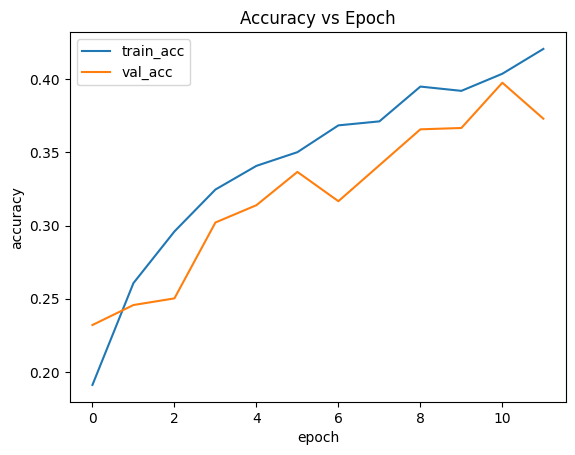

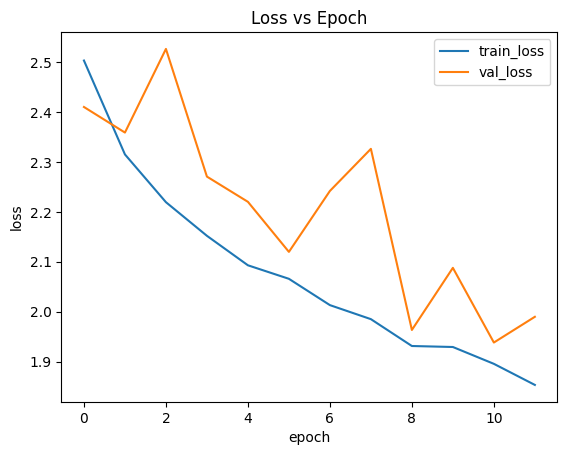

Best val_acc: 0.398 at epoch 11


In [ ]:
import matplotlib.pyplot as plt, numpy as np

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy vs Epoch")
plt.show()

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss vs Epoch")
plt.show()

val_accs = np.array(history["val_acc"])
best_ep = int(val_accs.argmax())+1
print(f"Best val_acc: {val_accs.max():.3f} at epoch {best_ep}")


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch

root_dir = "/root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2/train"

IMG_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# reload dataset with labels, then split
full_ds = datasets.ImageFolder(root=root_dir, transform=train_tfms)
num_classes = len(full_ds.classes)
n_total = len(full_ds)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test])
val_ds.dataset.transform  = eval_tfms
test_ds.dataset.transform = eval_tfms

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes, device


(15, device(type='cuda'))

Epoch 01/15 | train 0.206 2.488 | val 0.246 2.525 | 46.3s
Epoch 02/15 | train 0.272 2.324 | val 0.314 2.227 | 44.2s
Epoch 03/15 | train 0.314 2.223 | val 0.323 2.294 | 46.0s
Epoch 04/15 | train 0.339 2.154 | val 0.315 2.265 | 44.7s
Epoch 05/15 | train 0.372 2.101 | val 0.333 2.194 | 45.3s
Epoch 06/15 | train 0.387 2.041 | val 0.377 2.095 | 44.6s
Epoch 07/15 | train 0.401 1.996 | val 0.353 2.153 | 45.4s
Epoch 08/15 | train 0.407 1.978 | val 0.400 1.988 | 44.7s
Epoch 09/15 | train 0.431 1.920 | val 0.417 1.935 | 45.3s
Epoch 10/15 | train 0.444 1.890 | val 0.426 1.956 | 44.3s
Epoch 11/15 | train 0.460 1.846 | val 0.452 1.869 | 45.6s
Epoch 12/15 | train 0.470 1.807 | val 0.462 1.845 | 44.8s
Epoch 13/15 | train 0.488 1.774 | val 0.469 1.834 | 45.7s
Epoch 14/15 | train 0.496 1.755 | val 0.475 1.822 | 44.6s
Epoch 15/15 | train 0.500 1.739 | val 0.474 1.821 | 46.1s


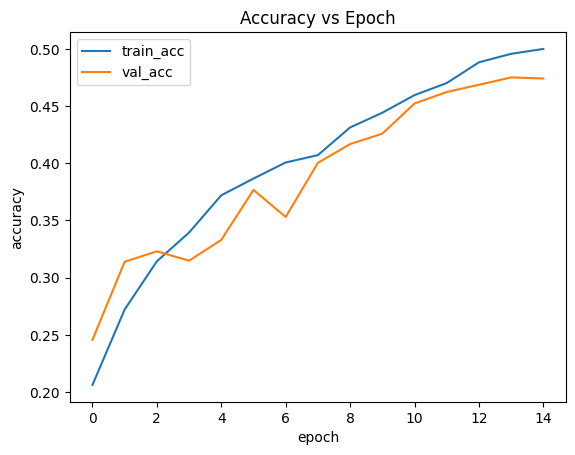

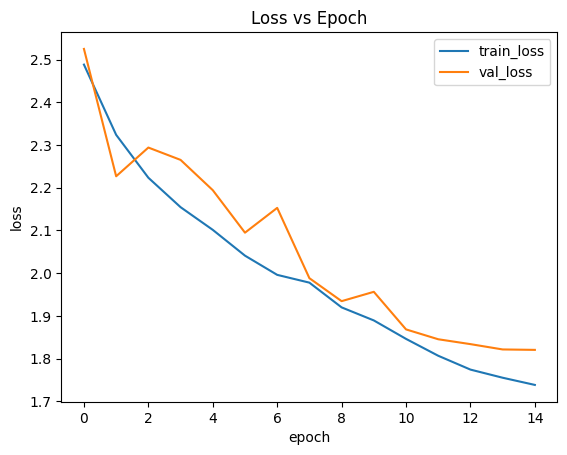

Best val_acc: 0.475 at epoch 14


In [ ]:
import time, numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
import torch.nn as nn

model = SmallGAPCNN(num_classes).to(device)

EPOCHS = 15
base_lr = 1.5e-3
weight_decay = 1e-4

optimizer = AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
scaler = GradScaler(device="cuda", enabled=(device.type=="cuda"))

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    ctx = torch.enable_grad() if train else torch.no_grad()
    with ctx:
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if train: optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=(device.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            n = x.size(0)
            total_loss += loss.item() * n
            total_acc  += accuracy(logits, y) * n
            total_n    += n
    return total_loss/total_n, total_acc/total_n

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tl, ta = run_epoch(train_loader, train=True)
    vl, va = run_epoch(val_loader,   train=False)
    scheduler.step()
    history["train_loss"].append(tl); history["train_acc"].append(ta)
    history["val_loss"].append(vl);   history["val_acc"].append(va)
    print(f"Epoch {epoch:02d}/{EPOCHS} | train {ta:.3f} {tl:.3f} | val {va:.3f} {vl:.3f} | {time.time()-t0:.1f}s")

import matplotlib.pyplot as plt
plt.figure(); plt.plot(history["train_acc"], label="train_acc"); plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy vs Epoch"); plt.show()
plt.figure(); plt.plot(history["train_loss"], label="train_loss"); plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss vs Epoch"); plt.show()

best_ep = int(np.argmax(history["val_acc"]))+1
print(f"Best val_acc: {max(history['val_acc']):.3f} at epoch {best_ep}")


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

# Train
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=2e-3, weight_decay=1e-4)


In [ ]:
from torch.amp import autocast, GradScaler
import time, numpy as np

EPOCHS = 8
scaler = GradScaler(device="cuda", enabled=(device.type=="cuda"))

history = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    train_loss, train_acc, n = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * x.size(0)
        train_acc  += accuracy(logits, y) * x.size(0)
        n += x.size(0)
    train_loss /= n
    train_acc  /= n

    model.eval()
    val_loss, val_acc, n = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with autocast(device_type="cuda", enabled=(device.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            val_acc  += accuracy(logits, y) * x.size(0)
            n += x.size(0)
    val_loss /= n
    val_acc  /= n

    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch}/{EPOCHS} | train {train_acc:.3f} {train_loss:.3f} | val {val_acc:.3f} {val_loss:.3f} | {time.time()-t0:.1f}s")

best_val = max(history["val_acc"])
print("Best val_acc:", best_val)


Epoch 1/8 | train 0.595 1.567 | val 0.757 1.081 | 43.9s
Epoch 2/8 | train 0.768 1.028 | val 0.796 1.004 | 41.2s
Epoch 3/8 | train 0.812 0.922 | val 0.801 0.960 | 44.2s
Epoch 4/8 | train 0.826 0.874 | val 0.803 0.951 | 41.1s
Epoch 5/8 | train 0.841 0.833 | val 0.787 0.961 | 41.6s
Epoch 6/8 | train 0.852 0.811 | val 0.805 0.956 | 41.2s
Epoch 7/8 | train 0.861 0.790 | val 0.811 0.916 | 41.4s
Epoch 8/8 | train 0.862 0.767 | val 0.819 0.907 | 42.0s
Best val_acc: 0.8189262971756565


Test accuracy: 0.8245454545454546
                   precision    recall  f1-score   support

american_football      0.955     0.778     0.857        54
         baseball      0.963     0.776     0.860        67
       basketball      0.976     0.816     0.889        49
    billiard_ball      0.849     0.900     0.874       100
     bowling_ball      0.746     0.862     0.800        58
     cricket_ball      0.901     0.869     0.885        84
         football      0.964     0.860     0.909        93
        golf_ball      0.648     0.854     0.737        82
      hockey_ball      0.746     0.553     0.635        85
      hockey_puck      0.864     0.773     0.816        66
       rugby_ball      0.794     0.818     0.806        66
      shuttlecock      0.821     0.917     0.866        60
table_tennis_ball      0.853     0.853     0.853        95
      tennis_ball      0.827     0.827     0.827        81
       volleyball      0.663     0.917     0.769        60

         accuracy   

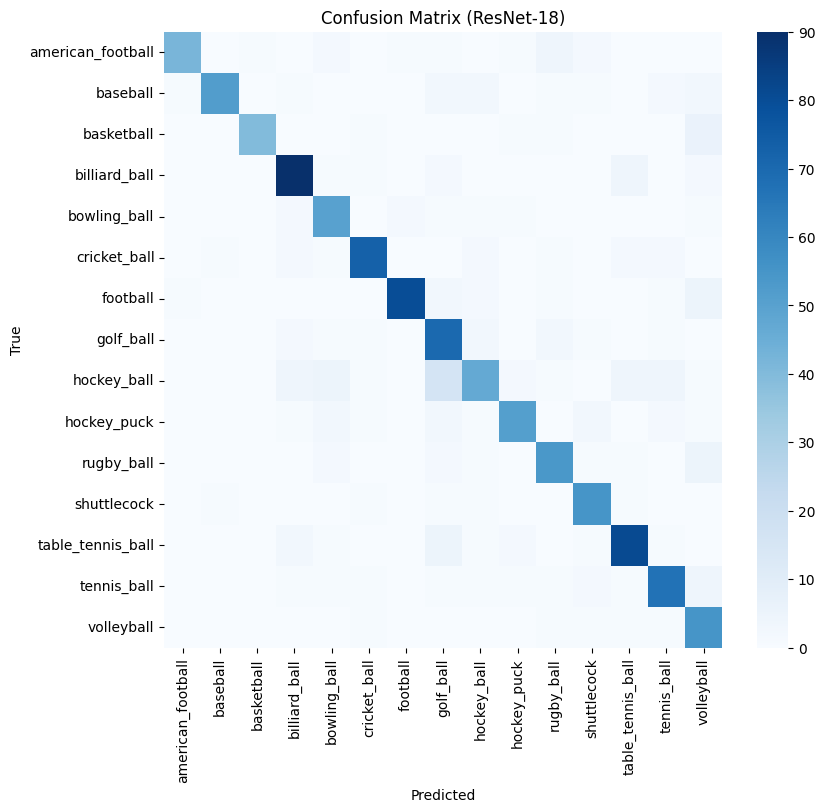

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        y_true.extend(y.numpy().tolist())
        y_pred.extend(logits.argmax(1).cpu().numpy().tolist())

print("Test accuracy:", np.mean(np.array(y_true)==np.array(y_pred)))
print(classification_report(y_true, y_pred, target_names=dataset.classes, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,8))
sns.heatmap(cm, cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (ResNet-18)")
plt.show()
